#  Games on a Network 

Fix a 2x2 game.  Each agent plays this game with her neighbors in a network. 

At each step: 

1. One agent (the focal agent) is chosen at random to adopt a new strategy
2. The focal agent chooses a new strategy based on how well her neighbors perform in the game: 
    * `imitation`: imitate the neighbor with the highest total score for that round
    * `prob_imitation`: select a neighbor to imitate proportional to the  average payouts

In [4]:
from mesa import Model, Agent
from mesa.batchrunner import BatchRunner
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import random

import nashpy as nash
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import widgets, interact, interact_manual
import seaborn as sns
import numpy as np
import pandas
import tqdm.notebook as tqdm
import seaborn as sns

sns.set()

In [5]:
# Create some games:

A = np.array([[3, 0], [4, 1]])
B = np.array([[3, 4], [0, 1]])
pd = nash.Game(A, B)
#print(pd)

A = np.array([[3, 0], [6, 1]])
B = np.array([[3, 6], [0, 1]])
pd2 = nash.Game(A, B)
#print(pd2)

A = np.array([[1, 0], [0, 1]])
B = np.array([[1, 0], [0, 1]])
coord = nash.Game(A, B)
#print(coord)

A = np.array([[2, 0], [0, 1]])
B = np.array([[2, 0], [0, 1]])
hilo = nash.Game(A, B)
#print(hilo)


A = np.array([[2, 0], [0, 1]])
B = np.array([[1, 0], [0, 2]])
bos = nash.Game(A, B)
#print(bos)

A = np.array([[4, 1], [3, 2]])
B = np.array([[4, 3], [1, 2]])
sh = nash.Game(A, B)
#print(sh)

A = np.array([[9, 0], [8, 7]])
B = np.array([[9, 8], [0, 7]])
sh2 = nash.Game(A, B)
#print(str(sh2))


In [6]:

# fix two strategies
S1 = np.array([1, 0])
S2 = np.array([0, 1])

STRATS = {
    "S1": S1,
    "S2": S2
}

class Player(Agent):
    '''
    A player for a game 
    '''
    def __init__(self, unique_id, pos, model, strat):

        super().__init__(unique_id, model)
        self.pos = pos
        self.strat = strat # fixed strategy to play in the game 

    def average_payout(self):
        '''find the average payout when playing the game against all neighbors'''
        neighbors = self.model.grid.neighbor_iter(self.pos)
        return np.average([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])
    
    def total_payout(self):
        '''find the total payout when playing the game against all neighbors'''
        neighbors = self.model.grid.neighbor_iter(self.pos)
        return np.sum([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])
    
    def step(self):
        pass

In [7]:
class GameLatticeModel(Model):
    '''
    Play a fixed game on a lattice.
    '''
    def __init__(self, height, width, game, bias_S1, num_changes_per_step, mutation, update_type):
        
        self.height = height
        self.width = width
        self.game = game
        self.bias_S1 = bias_S1
        self.update_type = update_type
        self.num_changes_per_step = num_changes_per_step
        self.mutation = mutation
        
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)
        
        self.datacollector = DataCollector(
             {"Percent S1": lambda m: np.sum([1 for a in m.schedule.agents 
                                              if   a.strat ==  "S1"]) / m.schedule.get_agent_count()}             )
        self.running = True
        
        # Set up agents
        agent_id = 0
        for cell in self.grid.coord_iter():
            _,x,y = cell
            strat = "S1" if random.random() < self.bias_S1 else "S2"
            agent = Player(agent_id, (x, y), self, strat)
            self.grid.position_agent(agent, x=x, y=y)
            self.schedule.add(agent)
            agent_id += 1
        
    def step(self):
        for i in range(self.num_changes_per_step):
            
            # choose a random agent
            focal_agent = np.random.choice(self.schedule.agents)
            
            # find all the neighbors of the agent
            neighbors = self.grid.get_neighbors(focal_agent.pos, moore=True)
            
            
            if self.update_type == 'imitator':
                # imitate most successful neighbor
                total_payouts  = {a: a.total_payout() for a in neighbors}

                max_payout = max(total_payouts.values())

                strat_to_imitate = [a.strat for a in total_payouts.keys() if total_payouts[a] == max_payout][0]

            if self.update_type == 'prob_imitator':
                
                # get the average payouts for each neighbor
                average_payouts = [a.average_payout() for a in neighbors]
                total_average_payouts = np.sum(average_payouts)
                
                # probabilities for each neighbor
                neighbor_probs = [n.average_payout() / total_average_payouts for n in neighbors]
                
                # probabilistically imitate most successful neighbor 
                strat_to_imitate = np.random.choice(neighbors, 1, p=neighbor_probs)[0].strat
            
            
            # mutations
            other_strat = "S2" if strat_to_imitate == "S1" else "S1"
            
            if random.random() < self.mutation:
                focal_agent.strat = other_strat
            else: 
                focal_agent.strat = strat_to_imitate
            
            self.datacollector.collect(self)
            
            self.schedule.steps += 1
        
        # stop running if all agents have the same strategy

        if all([a.strat == "S1" for a in self.schedule.agents]) or all([a.strat == "S2" for a in self.schedule.agents]):
            self.running=False
            
                        

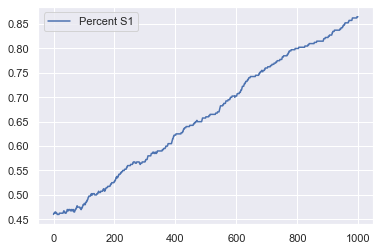

In [8]:

height, width = 20, 20 
game = sh
bias_S1 = 0.5
mutation = 0.0
update_type = 'imitator'
num_changes_per_step = 1
model = GameLatticeModel(height, width, 
                         game, bias_S1, 
                         num_changes_per_step, 
                         mutation, update_type)


for i in tqdm.tqdm(range(1000)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();

## Exploring the Parameter Space

In [9]:
def get_percentS1(m):
    '''
    Find the % of agents playing the strategy S1.
    '''
    
    return np.sum([1 for a in m.schedule.agents
                   if a.strat == "S1"]) / m.schedule.get_agent_count()


In [10]:
variable_params = {"mutation": [0.0, 0.1, 0.2, 0.3]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "imitator", 
                 "game": sh,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=5, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=False)

param_sweep.run_all()

df = param_sweep.get_model_vars_dataframe()
df

,mutation,Run,PercentS1,height,width,bias_S1,update_type,game,num_changes_per_step
0,0.0,0,0.8925,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
1,0.0,1,0.8925,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
2,0.0,2,0.9000,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
3,0.0,3,0.8850,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
4,0.0,4,0.9200,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
5,0.1,5,0.8525,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
6,0.1,6,0.8825,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
7,0.1,7,0.8050,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
8,0.1,8,0.7525,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1
9,0.1,9,0.8400,20,20,0.5,imitator,Bi matrix game with payoff matrices:\n\nRow pl...,1


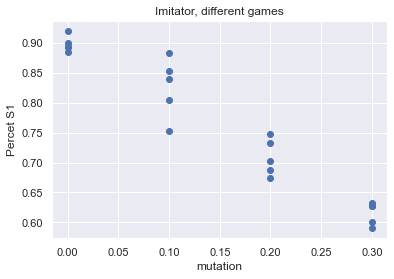

In [11]:
plt.scatter(df.mutation, df.PercentS1)
plt.title("Imitator, different games")
plt.ylabel("Percet S1")
plt.xlabel("mutation")
plt.grid(True)

In [12]:
variable_params = {"game": [pd, pd2, coord, hilo, bos, sh, sh2]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "update_type": "prob_imitator", 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=False)
param_sweep.run_all()

df = param_sweep.get_model_vars_dataframe()
df

,game,Run,PercentS1,height,width,bias_S1,update_type,mutation,num_changes_per_step
0,Bi matrix game with payoff matrices:\n\nRow pl...,0,0.3050,20,20,0.5,prob_imitator,0.0,1
1,Bi matrix game with payoff matrices:\n\nRow pl...,1,0.3875,20,20,0.5,prob_imitator,0.0,1
2,Bi matrix game with payoff matrices:\n\nRow pl...,2,0.3200,20,20,0.5,prob_imitator,0.0,1
3,Bi matrix game with payoff matrices:\n\nRow pl...,3,0.3900,20,20,0.5,prob_imitator,0.0,1
4,Bi matrix game with payoff matrices:\n\nRow pl...,4,0.2150,20,20,0.5,prob_imitator,0.0,1
...,...,...,...,...,...,...,...,...,...
65,Bi matrix game with payoff matrices:\n\nRow pl...,65,0.1625,20,20,0.5,prob_imitator,0.0,1
66,Bi matrix game with payoff matrices:\n\nRow pl...,66,0.2300,20,20,0.5,prob_imitator,0.0,1
67,Bi matrix game with payoff matrices:\n\nRow pl...,67,0.2075,20,20,0.5,prob_imitator,0.0,1
68,Bi matrix game with payoff matrices:\n\nRow pl...,68,0.2075,20,20,0.5,prob_imitator,0.0,1


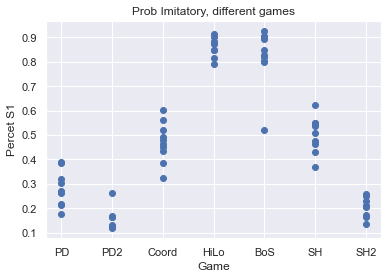

In [13]:
def convert_game_string(gstr):
    
    if gstr == str(pd):
        return "PD"
    if gstr == str(pd2):
        return "PD2"
    if gstr == str(coord):
        return "Coord"
    if gstr == str(hilo):
        return "HiLo"
    if gstr == str(bos):
        return "BoS"
    if gstr == str(sh):
        return "SH"
    if gstr == str(sh2):
        return "SH2"
    return gstr

plt.scatter([convert_game_string(str(g)) for g in df.game], df.PercentS1)
plt.title("Prob Imitatory, different games")
plt.ylabel("Percet S1")
plt.xlabel("Game")
plt.grid(True)

In [ ]:
variable_params = {"game": [pd, pd2, coord, hilo, bos, sh, sh2], 
                   "update_type": ["imitator", "prob_imitator"]}
fixed_params =  {"height": 20, 
                 "width": 20, 
                 "bias_S1": 0.5, 
                 "mutation": 0.0,
                 "num_changes_per_step": 1} 
model_reporters = {"PercentS1": get_percentS1}
param_sweep = BatchRunner(GameLatticeModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=1000, 
                          model_reporters=model_reporters, 
                          display_progress=False)

param_sweep.run_all()

df = param_sweep.get_model_vars_dataframe()
df

In [ ]:
def convert_game_string(gstr):
    
    if gstr == str(pd):
        return "PD"
    if gstr == str(pd2):
        return "PD2"
    if gstr == str(coord):
        return "Coord"
    if gstr == str(hilo):
        return "HiLo"
    if gstr == str(bos):
        return "BoS"
    if gstr == str(sh):
        return "SH"
    if gstr == str(sh2):
        return "SH2"
    return gstr

plt.scatter([convert_game_string(str(g)) for g in df[df["update_type"] == "imitator"].game],  
            df[df["update_type"] == "imitator"].PercentS1, label="Imitator")
plt.scatter([convert_game_string(str(g)) for g in df[df["update_type"] == "prob_imitator"].game], 
            df[df["update_type"] == "prob_imitator"].PercentS1, label="Prob Imitator")
plt.title("Different games")
plt.ylabel("Percet S1")
plt.xlabel("Game")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)

## Games on Graphs

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()

G.add_nodes_from([0,1,2,3,4,5,6,7])
G.add_edges_from([(0,1), (5, 1),  (1,2), (2,3), (3,4), (4,5),(5,6), (6,7), (7,0)])

nx.draw(G, with_labels = True, font_color="white", font_size=14,font_weight='bold')


In [ ]:
from mesa.space import NetworkGrid

# fix two strategies
S1 = np.array([1, 0])
S2 = np.array([0, 1])

STRATS = {
    "S1": S1,
    "S2": S2
}


class Player(Agent):
    '''
    A player for a game 
    '''
    def __init__(self, unique_id, pos, model, strat):

        super().__init__(unique_id, model)
        self.pos = pos
        self.strat = strat # fixed strategy to play in the game 

    def average_payout(self):
        '''find the average payout when playing the game against all neighbors'''
            
        neighbors_nodes = [a for a in self.model.network.get_neighbors(self.pos)]
            
        neighbors = [a for a in self.model.schedule.agents if a.pos in neighbors_nodes]
        return np.average([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])
    
    def total_payout(self):
        '''find the total payout when playing the game against all neighbors'''
        neighbors_nodes = [a for a in self.model.network.get_neighbors(self.pos)]
            
        neighbors = [a for a in self.model.schedule.agents if a.pos in neighbors_nodes]
        return np.sum([self.model.game[STRATS[self.strat], STRATS[n.strat]][0] for n in neighbors])

    
    
class GameNetworkModel(Model):
    '''
    Play a fixed game on a lattice.
    '''
    def __init__(self,  game, bias_S1,  mutation, update_type, network):
        
        self.height = height
        self.width = width
        self.game = game
        self.bias_S1 = bias_S1
        self.update_type = update_type
        self.num_changes_per_step = num_changes_per_step
        self.mutation = mutation
        
        self.schedule = RandomActivation(self)
        self.network = NetworkGrid(network)
        
        self.datacollector = DataCollector(
             {"Percent S1": lambda m: np.sum([1 for a in m.schedule.agents 
                                              if  a.strat == "S1"]) / m.schedule.get_agent_count()}             )
        self.running = True
        
        # Set up agents
        agent_id = 0
        for n in network.nodes:
            
            strat = "S1" if random.random() < self.bias_S1 else "S2"
            agent = Player(agent_id, n, self, strat)
            self.network.place_agent(agent, n)
            self.schedule.add(agent)
            agent_id += 1
        
    def step(self):
        for i in range(self.num_changes_per_step):
            
            # choose a random agent
            focal_agent = np.random.choice(self.schedule.agents)
            
            # find all the neighbors of the agent
            
            neighbors_nodes = [a for a in self.network.get_neighbors(focal_agent.pos)]
            
            neighbors = [a for a in self.schedule.agents if a.pos in neighbors_nodes]
            if self.update_type == 'imitator':
                # imitate most successful neighbor
                total_payouts  = {a: a.total_payout() for a in neighbors}

                max_payout = max(total_payouts.values())

                strat_to_imitate = [a.strat for a in total_payouts.keys() if total_payouts[a] == max_payout][0]

            if self.update_type == 'prob_imitator':
                
                # get the average payouts for each neighbor
                average_payouts = [a.average_payout() for a in neighbors]
                total_average_payouts = np.sum(average_payouts)
                
                # probabilities for each neighbor
                neighbor_probs = [n.average_payout() / total_average_payouts for n in neighbors]
                
                # probabilistically imitate most successful neighbor 
                strat_to_imitate = np.random.choice(neighbors, 1, p=neighbor_probs)[0].strat
            
            
            # mutations
            other_strat = "S2" if strat_to_imitate == "S1" else "S1"
            
            if random.random() < self.mutation:
                focal_agent.strat = other_strat
            else: 
                focal_agent.strat = strat_to_imitate
            
            self.datacollector.collect(self)
            
            # stop running if all agents have the same strategy
            if len(list(set([a.strat for a in self.schedule.agents]))) == 1:
                self.running=False
            
            

In [ ]:
height, weight = 10, 10
bias_S1 = 0.5  
mutation = 0
update_type = "prob_imitator"
game = sh

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)



In [ ]:
for i in tqdm.tqdm(range(100)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();

In [ ]:
G = nx.cycle_graph(100)

nx.draw(G, pos=nx.circular_layout(G), 
        with_labels = True, 
        font_color="white", 
        font_size=14,
        font_weight='bold')

bias_S1 = 0.5  
mutation = 0
update_type = "imitator"
game = pd

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)
for i in tqdm.tqdm(range(500)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();


In [ ]:
G = nx.star_graph(20)

nx.draw(G, pos=nx.circular_layout(G), with_labels = True, font_color="white", font_size=14,font_weight='bold')

bias_S1 = 0.5  
mutation = 0
update_type = "imitator"
game = sh

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)
for i in tqdm.tqdm(range(500)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();


In [ ]:
G = nx.complete_graph(20)

nx.draw(G, pos=nx.circular_layout(G), with_labels = True, font_color="white", font_size=14,font_weight='bold')
bias_S1 = 0.5
mutation = 0
update_type = "imitator"
game = coord

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)
for i in tqdm.tqdm(range(500)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();


In [ ]:
G = nx.petersen_graph()

nx.draw(G, pos=nx.circular_layout(G), with_labels = True, font_color="white", font_size=14,font_weight='bold')
bias_S1 = 0.5  
mutation = 0
update_type = "imitator"
game = pd2

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)
for i in tqdm.tqdm(range(500)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();


In [ ]:
G = nx.erdos_renyi_graph(20, 0.2)

nx.draw(G, pos=nx.circular_layout(G), with_labels = True, font_color="white", font_size=14,font_weight='bold')
bias_S1 = 0.5  
mutation = 0
update_type = "imitator"
game = pd

model = GameNetworkModel(game, 
                         bias_S1, 
                         mutation, 
                         update_type, 
                         G)
for i in tqdm.tqdm(range(500)):
# initialize the model
    model.step()
    if not model.running:
        break
        
model_out = model.datacollector.get_model_vars_dataframe()
model_out.plot();
